<a href="https://colab.research.google.com/github/sushmit86/Statiistical_rethinking_jax/blob/main/sushmit_02_small_worlds_and_large_worlds_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
  !pip install jaxopt
except:
  pass

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
%load_ext watermark

In [ ]:
import numpy as np
import jax
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp_jax
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from jax.scipy.optimize import minimize
import scipy.stats as stats
import arviz as az
tfd_jax = tfp_jax.distributions
key = jax.random.PRNGKey(1)

In [ ]:
%watermark -p numpy,tensorflow,tensorflow_probability,scipy,pandas,jax,jaxopt

numpy                 : 1.23.5
tensorflow            : 2.15.0
tensorflow_probability: 0.22.0
scipy                 : 1.11.4
pandas                : 1.5.3
jax                   : 0.4.23
jaxopt                : 0.8.2



# Code 2.1

In [ ]:
ways = jnp.array([0.0, 3, 8, 9, 0])
new_ways = ways /jnp.sum(ways)
new_ways

Array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)

# Code 2.2
- Probability of getting 6 sucess out 9 toss with equal probability

In [ ]:
W = 6
L = 3
tfd_jax.Binomial(total_count = W +L, probs= 0.5).prob(W)

Array(0.16406271, dtype=float32)

# Code 2.3

In [ ]:
#@title Grid approximation
# create a grid
n_points = 20
grid = jnp.linspace(0,1,n_points)
# create the prior Uniform distribution
prior = jnp.ones_like(grid)
# Likelihood = Binomial
unstd_post = prior * tfd_jax.Binomial(total_count = W +L,probs=grid).prob(W)
std_post = unstd_post/unstd_post.sum()
fig = px.line(x=grid,y=std_post,markers = True)
fig.update_layout( autosize=False,
    width=500,
    height=500)
fig.show()

# Code 2.4

In [ ]:
# first_prior = tf.where(condition=p_grid < 0.5, x=0.0, y=1)
# second_prior = tf.exp(-5 * abs(p_grid - 0.5))

## first prior p_grid less than 0.5 then 0 else 1
first_prior = jnp.where(grid < 0.5,0 ,1)
second_prior = jnp.exp(-5 * abs(grid - 0.5))
likelihood = tfd_jax.Binomial(total_count = W +L,probs=grid).prob(W)
first_posterior = first_prior * likelihood
second_posterior = second_prior * likelihood

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("First prior", "Second prior",
                                    "First posterior", "Second posterior"))

fig.add_trace(go.Scatter(x = grid, y = first_prior),row =1, col=1)
fig.add_trace(go.Scatter(x = grid, y = second_prior),row =1, col=2)

fig.add_trace(go.Scatter(x = grid, y = first_posterior),row =2, col=1)
fig.add_trace(go.Scatter(x = grid, y = second_posterior),row =2, col=2)


fig.show()


# Code 2.6

In [ ]:
#@title Quadratic Approximation
## Approximate using the hessian and normal distb
## few concepts -- you need BFGS optimizer, grad
## first we need define the log likehoof
key = jax.random.PRNGKey(11)
dist = tfd_jax.JointDistributionNamed(
    {
        "probability":tfd_jax.Uniform(low= 0.0, high = 1.0),
        "water": lambda probability:tfd_jax.Binomial(total_count = W +L,probs = probability)
    }
)
def neg_log_prob(x):
    return tfp_jax.math.value_and_gradient(
        lambda p: -dist.log_prob(
            water=W, probability= jnp.clip(p[-1],0,1)),
        x,
    )


optim_results = tfp_jax.optimizer.bfgs_minimize(neg_log_prob,
                                                initial_position=[0.5],
                                                tolerance = 1e-6)
assert(optim_results.converged)

print(optim_results)
mean = optim_results.position
std_dev = jnp.sqrt(optim_results.inverse_hessian_estimate)
quad_approx_dist = tfd_jax.Normal(loc = mean,scale = std_dev)

BfgsOptimizerResults(converged=Array(True, dtype=bool), failed=Array(False, dtype=bool), num_iterations=Array(4, dtype=int32), num_objective_evaluations=Array(13, dtype=int32), position=Array([0.6666667], dtype=float32), objective_value=Array(1.2978106, dtype=float32), objective_gradient=Array([9.536743e-07], dtype=float32), inverse_hessian_estimate=Array([[0.02470744]], dtype=float32))


In [ ]:
print(
    "mean:",
    quad_approx_dist.mean(),
    "\nstandard deviation: ",
    quad_approx_dist.stddev(),
)

mean: [[0.6666667]] 
standard deviation:  [[0.157186]]


In [ ]:
# test_fn = lambda x: -dist.log_prob(water=W, probability= jnp.clip(x,0,1))[0]

# optim_scipy_results = minimize(test_fn,x0 = jnp.array([0.5]),method="BFGS",tol=1e-6)
# optim_scipy_results

# Code 2.7

In [ ]:
analytical_solution = tfd_jax.Beta(concentration1 = 1+W, concentration0 = 1+L)
grid = jnp.linspace(0,1,100)
df_soln = pd.DataFrame({'x':grid,'analytical_solution':analytical_solution.prob(grid),
             'quad_approx':quad_approx_dist.prob(grid).reshape(100,)})
fig = px.line(df_soln, x='x', y=['analytical_solution', 'quad_approx'])

fig.show()

# Code 2.8
- Apply MCMC

In [ ]:
n_samples = 1000
p = jnp.zeros(n_samples)
W = 6
L = 3
for i in range(1,n_samples):
  key, subkey = jax.random.split(key)
  # p_new = tfd_jax.Normal(loc = p[i-1], scale = 0.1).sample(seed=key)
  p_new =  0.1*jax.random.normal(key) + p[i-1]
  if p_new < 0:
    p_new = abs(p_new)
  if p_new > 1:
    p_new = 2 - p_new
  q0 = jax.scipy.stats.binom.pmf(W, W+L, p[i-1])
  q1 = jax.scipy.stats.binom.pmf(W, W+L, p_new)

  if jax.random.uniform(key) < q1/q0:
    p = p.at[i].set(p_new)
  else:
    p = p.at[i].set(p[i-1])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.

/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:957: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "histogram" failed type inference due to: No implementation of function Function(<function histogram at 0x7b1a2c338430>) found for signature:
 
 >>> histogram(readonly buffer(float32, 1d, C), bins=int64, range=UniTuple(readonly buffer(float32, 0d, C) x 2))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'np_histogram': File: numba/np/arraymath.py

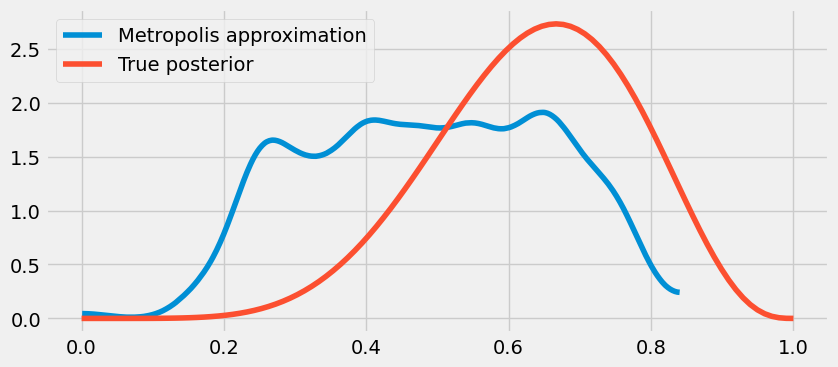

In [ ]:
_, ax = plt.subplots(figsize=(9, 4))

az.plot_kde(p, label="Metropolis approximation", ax=ax)
x = jnp.linspace(0.0, 1.0, 100)
ax.plot(x, tfd_jax.Beta(W + 1, L + 1).prob(x), "C1", label="True posterior")
ax.legend();

In [ ]:
## implementing the algo in numpy,scipy

# import numpy as np
# from scipy import stats
# n_samples = 1000
# p = np.zeros(n_samples)
# p[0] =0.5
# W =6
# L = 3
# for i in range(1,n_samples):
#   p_new = stats.norm(loc = p[i-1], scale = 0.1).rvs()
#   if p_new < 0:
#     p_new = abs(p_new)
#   if p_new > 1:
#     p_new = 2 - p_new
#   q0 = stats.binom.pmf(W, W+L, p[i-1])
#   q1 = stats.binom.pmf(W, W+L, p_new)
#   if stats.uniform.rvs() < q1/q0:
#     p[i] = p_new
#   else:
#     p[i] = p[i-1]

In [ ]:
# _, ax = plt.subplots(figsize=(9, 4))

# az.plot_kde(p, label="Metropolis approximation", ax=ax)
# x = jnp.linspace(0.0, 1.0, 100)
# ax.plot(x, tfd_jax.Beta(W + 1, L + 1).prob(x), "C1", label="True posterior")
# ax.legend();